In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy as sp

In [2]:
data_dir = Path(r'C:\Users\sebas\Documents\MATLAB\DataProCiencia\DeepLearning\raw')
file_name = 'rf_qus_AC_INCrand_1'
data_dict = sp.io.loadmat(str(data_dir / file_name))
data_dict.keys()
data_dict['alpha_mean']

array([[0.65, 1.  ]])

In [3]:
x = data_dict['x'].squeeze()
z = data_dict['z'].squeeze()
rf = data_dict['rf']
alpha = data_dict['alpha_mean']

dx = x[1] - x[0]
x_offset = x[0]*100
dz = z[1] - z[0]
x = 100*x
z = 100*z


In [4]:
def get_Bmode(rf):
    Bmode = 20*np.log10(np.abs(sp.signal.hilbert(rf,axis=0)))
    Bmode = Bmode - np.max(Bmode,axis=1,keepdims=True)
    return Bmode

Bmode = get_Bmode(rf)

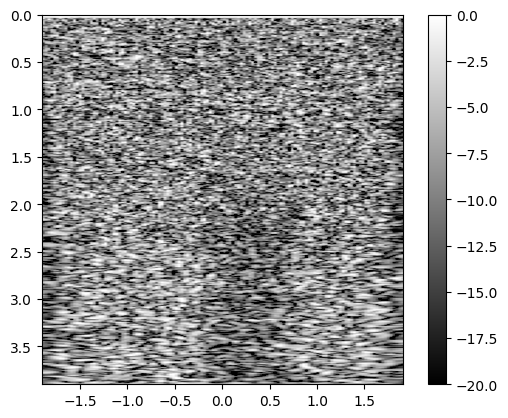

In [5]:
extent = (x[0], x[-1], z[-1], z[0])
plt.imshow(Bmode, cmap='gray', extent=extent)
plt.clim([-20,0])
plt.colorbar()
plt.show()

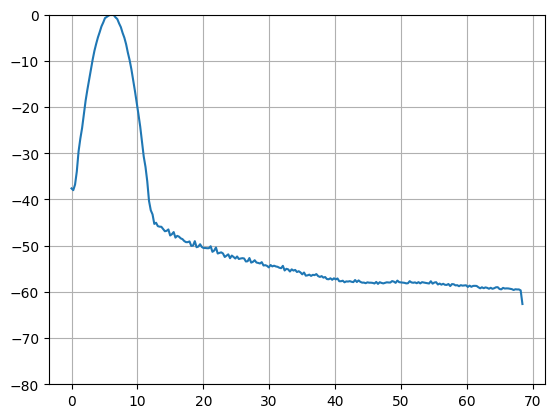

In [6]:
fs = data_dict['fs']
c0 = data_dict['sos_mean']
# spect = np.fft.fft(rf-np.mean(rf), axis=1)
# spect = np.mean(spect, axis=0)
f, spect = sp.signal.welch(rf, fs=fs, nperseg=512, nfft=512, axis=0, window=('tukey',0.25))
spect = np.mean(spect, axis=1)
spect = 10*np.log10(spect)
spect = spect - np.max(spect)
# print(spect.shape)

plt.plot(np.squeeze(f/1e6),spect)
# plt.xlim(0,15)
plt.ylim(-80,0)
plt.grid()
plt.show()

# wl = 2*c0/

### Downsampling
Run once

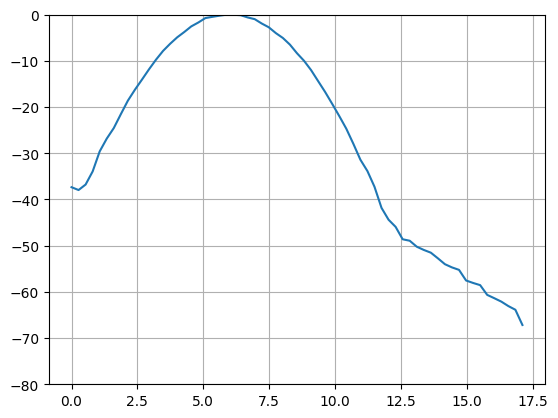

In [240]:
D = 4
b,a = sp.signal.butter(4,0.2)
rf = sp.signal.filtfilt(b,a,rf,axis=0)
rf = rf[::D,:]
fs = fs/D
z = z[::D]
dz = dz*D

f, spect = sp.signal.welch(rf, fs=fs, nperseg=128, nfft=128, axis=0, window=('tukey',0.25))
spect = np.mean(spect, axis=1)
spect = 10*np.log10(spect)
spect = spect - np.max(spect)
# print(spect.shape)

plt.plot(np.squeeze(f/1e6),spect)
# plt.xlim(0,15)
plt.ylim(-80,0)
plt.grid()
plt.show()


# Local spectra

In [165]:
blocksize = 5
freq_L = 2e6; freq_H = 10e6

overlap_pc      = 0.8
ratio_zx        = 2
referenceAtt    = 0.5

In [166]:
# Wavelength size
c0 = 1540
freq_C = 6e6 
wl = c0/freq_C


In [167]:
# Lateral samples
wx = round(blocksize*wl*(1-overlap_pc)/dx)  # Between windows
nx = round(blocksize*wl/dx)                # Window size
x0 = np.arange(0,len(x)-nx,wx)
x_ACS = x[x0+round(nx/2)]
n  = len(x0)


In [168]:
# Axial samples
wz = round(blocksize*wl*(1-overlap_pc)/dz * ratio_zx); # Between windows
nz = 2*round(blocksize*wl/dz /2 * ratio_zx); # Window size
L = (nz/2)*dz*100; 
z0p = np.arange(0,len(z)-nz,wz)
z0d = z0p + nz//2
z_ACS = z[z0p+ nz//2]
m  = len(z0p)


In [169]:
windowing = sp.signal.windows.tukey(nz//2, alpha=0.25)
windowing = np.expand_dims(windowing, axis = 1)

NFFT = np.int32(2**np.ceil(np.log2(nz)))


In [170]:
# Frequency samples
band = np.arange(NFFT)/NFFT * fs
rang = (band > freq_L) & (band < freq_H)
f  = band[rang]*1e-6
p = len(f)


### Spectral log difference

In [171]:
def spectra(block,windowing,NFFT):
    block = block - np.mean(block, axis = 1, keepdims=True)
    block = block*windowing

    spect = abs(np.fft.fft(block,NFFT,1))
    spect = spect**2 
    spect = np.mean(spect,axis=0,keepdims=True)
    return spect

Sp = np.zeros((m,n,p))
Sd = np.zeros((m,n,p))
for jj in range(n):
    for ii in range(m):
        xw = x0[jj]
        zp = z0p[ii]
        zd = z0d[ii]

        sub_block_p = rf[zp:zp+nz//2,xw:xw+nx]
        sub_block_d = rf[zd:zd+nz//2,xw:xw+nx]

        tempSp = spectra(sub_block_p,windowing,NFFT)
        tempSd = spectra(sub_block_d,windowing,NFFT)
        
        Sp[ii,jj,:] = tempSp[rang]
        Sd[ii,jj,:] = tempSd[rang]


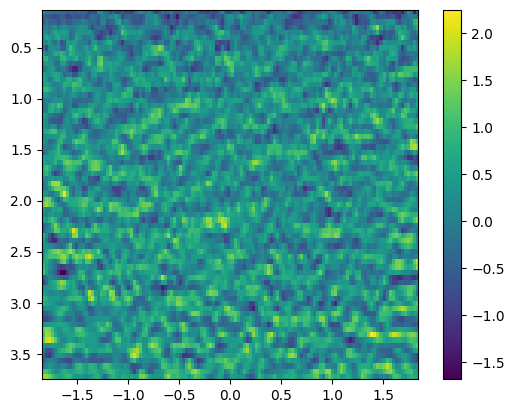

In [177]:
sld = np.log(Sp) - np.log(Sd)
extent = (x_ACS[0],x_ACS[-1],z_ACS[-1],z_ACS[0])
plt.imshow(sld[:,:,25], extent=extent)
plt.colorbar()
plt.show()

[]

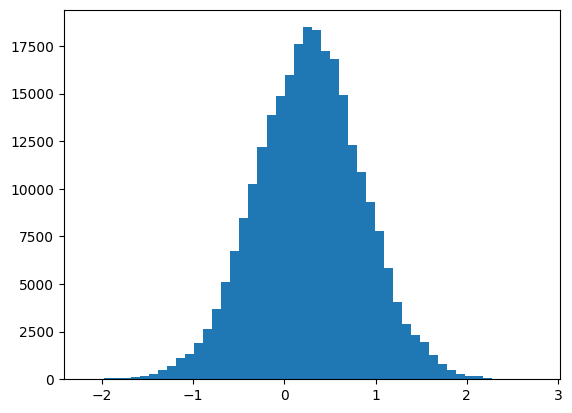

In [178]:
plt.hist(sld.flatten(),50)
plt.plot()

## Local spectra

In [179]:
windowing2 = sp.signal.windows.tukey(nz, alpha=0.25)
windowing2 = np.expand_dims(windowing2, axis = 1)

Spd = np.zeros((m,n,p))
for jj in range(n):
    for ii in range(m):
        xw = x0[jj]
        zp = z0p[ii]

        sub_block = rf[zp:zp+nz,xw:xw+nx]

        tempSpd = spectra(sub_block,windowing2,NFFT)
        Spd[ii,jj,:] = tempSpd[rang]

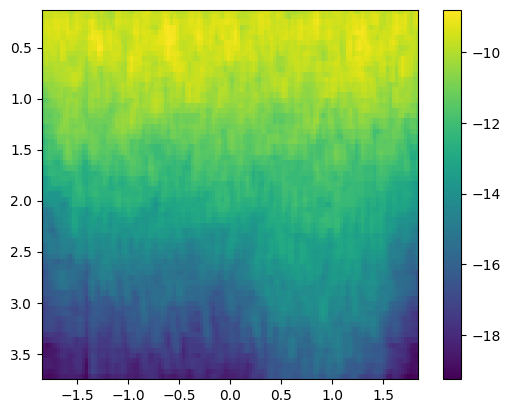

In [180]:
extent = (x_ACS[0],x_ACS[-1],z_ACS[-1],z_ACS[0])
logS = np.log(Spd)
plt.imshow(logS[:,:,25], extent=extent)
plt.colorbar()
plt.show()

[]

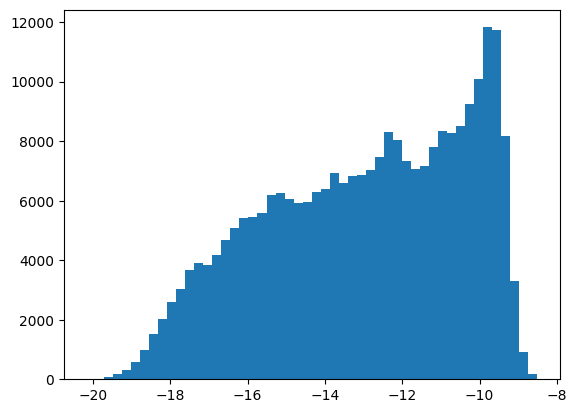

In [181]:
plt.hist(logS.flatten(),50)
plt.plot()

## Ideal attenuation map

In [241]:
alpha_back = data_dict['alpha_mean'][0,0]
alpha_inc = data_dict['alpha_mean'][0,1]
cx = data_dict['center_meters'][0,0]*100 + x_offset
cz = data_dict['center_meters'][0,1]*100
r = data_dict['radius_meters'][0,0]*100

[]

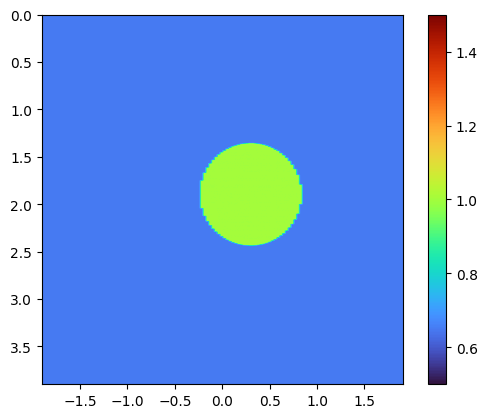

In [252]:
xv, zv = np.meshgrid(x, z, indexing='xy')
inc = ((xv - cx)**2 + (zv - cz)**2) < r**2

att_ideal = np.ones(xv.shape)*alpha_back
att_ideal[inc] = alpha_inc
plt.imshow(att_ideal, extent=extent, cmap='turbo')
plt.clim(0.5,1.5)
plt.colorbar()
plt.plot()

## Smoothed ACS

In [253]:
y = np.zeros((m,n))
for jj in range(n):
    for ii in range(m):
        xw = x0[jj]
        zp = z0p[ii]

        sub_block = att_ideal[zp:zp+nz,xw:xw+nx]
        y[ii,jj] = np.mean(sub_block)

[]

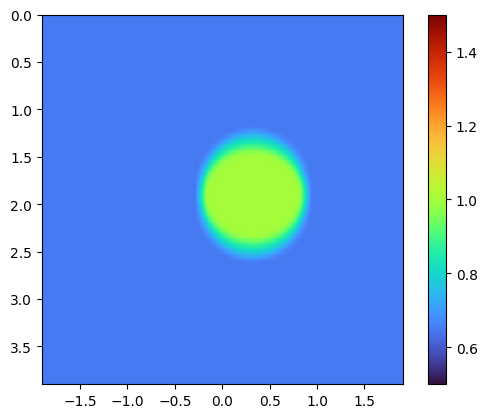

In [255]:
plt.imshow(y, extent=extent, cmap='turbo')
plt.clim(0.5,1.5)
plt.colorbar()
plt.plot()

In [256]:
p

30